# Fashion MNIST Autoencoder


This notebook demonstrates the implementation of an autoencoder using the Fashion MNIST dataset.
The autoencoder is a neural network that learns to encode input data into a smaller representation
and then decodes it back to the original form. In this example, we add noise to the images and train
the autoencoder to reconstruct the original images.


### import libarires

In [1]:

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from tensorflow.keras.models import Model
import tensorflow as tf


### Load the Fashion MNIST dataset

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Bulit the model with auto encdoder

### Flatten the images for MLP input

In [3]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

# Verify the shape of the flattened images
print("X_train_flatten shape:", X_train_flatten.shape)
print("X_test_flatten shape:", X_test_flatten.shape)

# Normalize the pixel values to be between 0 and 1
X_train_flatten1 = X_train_flatten.astype('float32') / 255.0
X_test_flatten1 = X_test_flatten.astype('float32') / 255.0

X_train_flatten shape: (60000, 784)
X_test_flatten shape: (10000, 784)


###  Create a Sequential model for the autoencoder


In [4]:
model_en = Sequential()
model_en.add(Dense(512, input_dim=784, activation='relu'))  # Encoder layer 1
model_en.add(Dense(256, activation='relu'))  # Encoder layer 2

model_en.add(Dense(64, activation='relu'))  # Bottleneck (encoding space)
model_en.add(Dense(256, activation='relu'))  # Decoder layer 1

model_en.add(Dense(512, activation='relu'))  # Decoder layer 2
model_en.add(Dense(784, activation='sigmoid'))  # Reconstructed output

model_en.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
import tensorflow as tf
tf.keras.backend.clear_session()  # Clear any previous TensorFlow session


In [6]:
history1 = model_en.fit(X_train_flatten1, X_train_flatten1,
                        epochs=5, batch_size=128,
                        validation_data=(X_test_flatten1, X_test_flatten1))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.0102 - loss: 0.3774 - val_accuracy: 0.0147 - val_loss: 0.2953
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0172 - loss: 0.2901 - val_accuracy: 0.0273 - val_loss: 0.2855
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0219 - loss: 0.2815 - val_accuracy: 0.0278 - val_loss: 0.2802
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0278 - loss: 0.2773 - val_accuracy: 0.0297 - val_loss: 0.2776
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0318 - loss: 0.2741 - val_accuracy: 0.0313 - val_loss: 0.2755


### Add noise to the images for a denoising autoencoder

In [7]:

# Add noise to the images for a denoising autoencoder
noise_factor = 0.2
x_train_noisy = X_train_flatten1 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_flatten1.shape)
x_test_noisy = X_test_flatten1 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_flatten1.shape)

# Clip the noisy images to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


### Define the Autoencoder architecture for denoising


In [8]:
input_img = Input(shape=(x_train_noisy.shape[1],))

# Add the encoder layers
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

# Add the bottleneck layer
bottleneck = Dense(16, activation='relu')(encoded)

# Add the decoder layers
decoded = Dense(32, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(X_train_flatten1.shape[1], activation='sigmoid')(decoded)

# Create the autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the autoencoder model
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')


### Train the autoencoder model

In [9]:

# Train the autoencoder model
history = autoencoder.fit(x_train_noisy, X_train_flatten1,
                          epochs=5, batch_size=256,
                          shuffle=True,
                          validation_data=(x_test_noisy, X_test_flatten1))


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.5161 - val_loss: 0.3499
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3396 - val_loss: 0.3235
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3186 - val_loss: 0.3142
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3114 - val_loss: 0.3103
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3074 - val_loss: 0.3078


### Evaluate the model on test data

In [10]:
loss = autoencoder.evaluate(x_test_noisy, X_test_flatten1)
print(f'Test loss: {loss}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3076
Test loss: 0.30782684683799744


In [11]:

# Function to display original, noisy, and reconstructed images
def display_reconstruction(original, noisy, reconstructed, num_images=10):
    plt.figure(figsize=(20, 6))
    for i in range(num_images):
        # Display original images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title("Original")

        # Display noisy images
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title("Noisy")

        # Display reconstructed images
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title("Denoised")
    plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


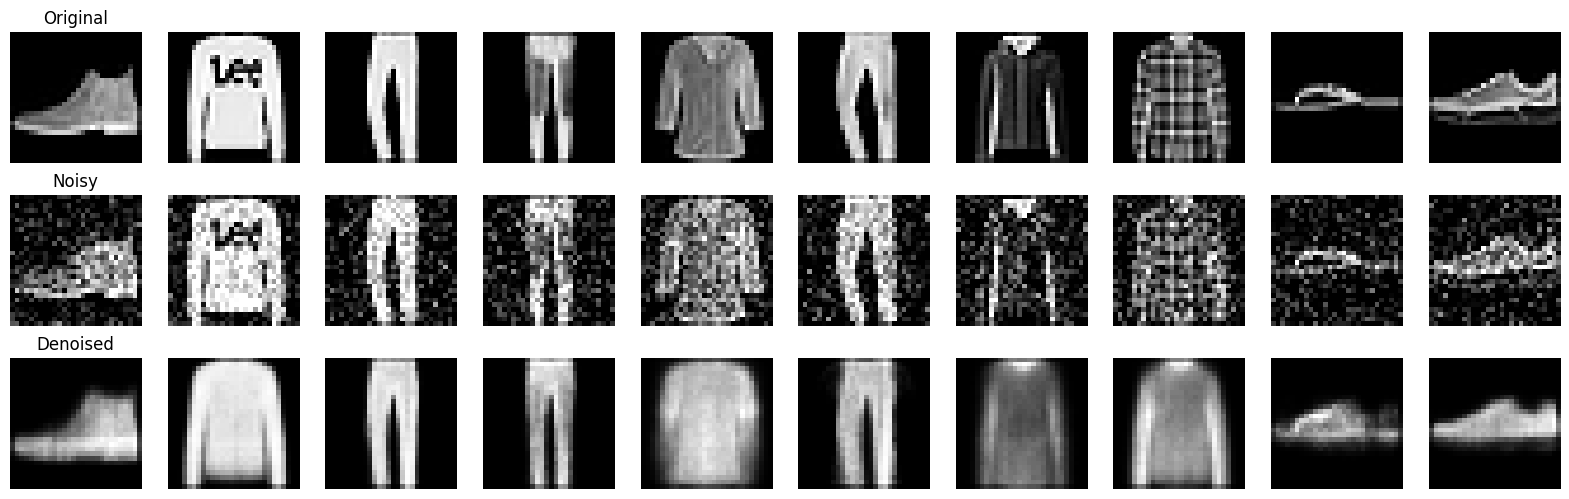

In [12]:

# Intermediate model to get encoded representations
encoder = Model(input_img, bottleneck)

# Get reconstructions and encoded images
reconstructed_imgs = autoencoder.predict(x_test_noisy)

# Display some original, noisy, and reconstructed images
display_reconstruction(X_test, x_test_noisy, reconstructed_imgs)
